In [1]:
!pip install wandb pyyaml opencv-python;

In [2]:
import os
import yaml
import glob
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
import wandb
from wandb.integration.keras import WandbCallback

2025-05-08 20:09:05.972856: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-08 20:09:05.990805: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-08 20:09:05.996182: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-08 20:09:06.010550: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-08 20:09:06.804437: W tensorflow/compiler/tf2

In [3]:
wandb.login(key="017feefe0af6702cda76aab121ec71cf3a362fec")

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/jovyan/.netrc
wandb: Currently logged in as: samutheman (rueedi-tobias-hochschule-luzern) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
dataset_yaml = "/exchange/dspro2/M-AI-ZE/data/adjusted/1.1/splits/SID01/data.yaml"
images_trainset = "/exchange/dspro2/M-AI-ZE/data/adjusted/1.1/splits/SID01/images/train"
labels_trainset = "/exchange/dspro2/M-AI-ZE/data/adjusted/1.1/splits/SID01/labels/train"
images_valset = "/exchange/dspro2/M-AI-ZE/data/adjusted/1.1/splits/SID01/images/val"
labels_valset = "/exchange/dspro2/M-AI-ZE/data/adjusted/1.1/splits/SID01/labels/val"
images_testset = False#"/exchange/dspro2/M-AI-ZE/data/adjusted/1.1/splits/SID01/images/test"
labels_testset = False#"/exchange/dspro2/M-AI-ZE/data/adjusted/1.1/splits/SID01/labels/test"


In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
with open(dataset_yaml, "r") as f:
    config = yaml.safe_load(f)


In [7]:
# --- Parameters (tweak these to your dataset) ---
IMG_SIZE    = 256
GRID_SIZE   = 4
NUM_CLASSES = 1   #
NUM_BOXES   = 1    # number of anchors per cell
OUTPUT_SHAPE = (GRID_SIZE, GRID_SIZE, NUM_BOXES * (5 + NUM_CLASSES))

In [8]:
def build_yolo_model(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    inputs = tf.keras.Input(shape=input_shape)
    def conv_bn_leaky(x, filters):
        x = layers.Conv2D(filters, 3, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        return layers.LeakyReLU(alpha=0.1)(x)

    x = conv_bn_leaky(inputs, 16)
    x = layers.MaxPool2D(2)(x)
    x = conv_bn_leaky(x, 32)
    x = layers.MaxPool2D(2)(x)
    x = conv_bn_leaky(x, 64)
    x = layers.MaxPool2D(2)(x)
    x = conv_bn_leaky(x, 128)
    x = layers.MaxPool2D(2)(x)
    x = conv_bn_leaky(x, 256)
    x = layers.MaxPool2D(2)(x)
    x = conv_bn_leaky(x, 512)
    x = layers.MaxPool2D(2)(x)
    x = conv_bn_leaky(x, 512)

    # prediction layer
    x = layers.Conv2D(
        NUM_BOXES * (5 + NUM_CLASSES),
        kernel_size=1,
        padding='same',
        activation='sigmoid'
    )(x)
    output = layers.Reshape((GRID_SIZE, GRID_SIZE, NUM_BOXES, 5 + NUM_CLASSES))(x)

    return tf.keras.Model(inputs, output)

In [9]:
# --- YOLO loss with binary class ---
def yolo_loss(y_true, y_pred):
    # reshape to (..., S, S, B, 5 + C)
    pred = tf.reshape(y_pred, (-1, GRID_SIZE, GRID_SIZE, NUM_BOXES, 5 + NUM_CLASSES))
    true = tf.reshape(y_true, (-1, GRID_SIZE, GRID_SIZE, NUM_BOXES, 5 + NUM_CLASSES))
    obj_mask = true[..., 4:5]

    # localization losses
    xy_loss = tf.reduce_sum(obj_mask * tf.square(true[..., 0:2] - pred[..., 0:2]))
    wh_loss = tf.reduce_sum(obj_mask * tf.square(
        tf.sqrt(true[..., 2:4] + 1e-6) - tf.sqrt(pred[..., 2:4] + 1e-6)
    ))

    # objectness and class losses
    obj_loss = tf.reduce_sum(
        tf.keras.losses.binary_crossentropy(true[..., 4:5], pred[..., 4:5])
    )
    class_bce = tf.keras.losses.binary_crossentropy(true[..., 5:], pred[..., 5:])
    class_bce = tf.expand_dims(class_bce, axis=-1)
    class_loss = tf.reduce_sum(obj_mask * class_bce)

    return xy_loss + wh_loss + obj_loss + class_loss

In [10]:
def load_yolo_dataset(image_dir, label_dir, img_size=IMG_SIZE):
    image_paths = sorted(glob.glob(os.path.join(image_dir, "*.jpg")))
    x_data, y_data = [], []

    # Prepare output shape dynamically if not predefined
    output_shape = (GRID_SIZE, GRID_SIZE, 5 + NUM_CLASSES)

    for img_path in image_paths:
        filename = os.path.splitext(os.path.basename(img_path))[0]
        label_path = os.path.join(label_dir, f"{filename}.txt")

        # Load and preprocess image
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_size, img_size))
        # Ensure float32 to save memory
        img = img.astype(np.float32) / 255.0
        x_data.append(img)

        # Create empty label grid
        label = np.zeros(output_shape, dtype=np.float32)

        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                lines = f.readlines()

            for line in lines:
                class_id, x, y, w, h = map(float, line.strip().split())
                
                # Compute cell indices, clamped to valid range
                gx = min(int(x * GRID_SIZE), GRID_SIZE - 1)
                gy = min(int(y * GRID_SIZE), GRID_SIZE - 1)

                # Relative coordinates within the cell
                cell_x = x * GRID_SIZE - gx
                cell_y = y * GRID_SIZE - gy

                # Assign bounding-box attributes and objectness
                label[gy, gx, 0:5] = cell_x, cell_y, w, h, 1.0
                # One-hot class vector starting at channel 5
                label[gy, gx, 5 + int(class_id)] = 1.0

        y_data.append(label)

    return np.array(x_data, dtype=np.float32), np.array(y_data, dtype=np.float32)

In [11]:
x_train, y_train = load_yolo_dataset(images_trainset, labels_trainset)
x_val, y_val     = load_yolo_dataset(images_valset, labels_valset)
if images_testset:
    x_test, y_test = load_yolo_dataset(images_testset , labels_testset)

In [12]:
x_train = np.array(x_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
x_val   = np.array(x_val,   dtype=np.float32)
y_val   = np.array(y_val,   dtype=np.float32)

In [13]:
wandb.init(project="Own CNN", name="Detector", config=config)

In [14]:
print("x_train type:", type(x_train))
print("x_train shape:", getattr(x_train, 'shape', 'No shape'))
print("y_train shape:", getattr(y_train, 'shape', 'No shape'))
#print("First element:", x_train[0])
#print("First element ", x_train[0])

x_train type: <class 'numpy.ndarray'>
x_train shape: (10858, 256, 256, 3)
y_train shape: (10858, 4, 4, 6)


In [15]:
model = build_yolo_model()
model.compile(optimizer='adam', loss=yolo_loss)
model.summary()

2025-05-08 20:10:09.560815: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13294 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:05:00.0, compute capability: 8.6
/opt/conda/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 16)   │           432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256, 256, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 256)    │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 512)      │     1,179,648 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,940,214 (15.03 MB)

 Trainable params: 3,937,174 (15.02 MB)

 Non-trainable params: 3,040 (11.88 KB)

In [16]:
batch_size = 4  # try smaller if still OOM

train_ds = (
    tf.data.Dataset
      .from_tensor_slices((x_train, y_train))
      .shuffle(1024)
      .batch(batch_size)
      .prefetch(tf.data.AUTOTUNE)
)

val_ds = (
    tf.data.Dataset
      .from_tensor_slices((x_val, y_val))
      .batch(batch_size)
      .prefetch(tf.data.AUTOTUNE)
)

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[WandbCallback(save_graph=False, save_model=False)]
)

2025-05-08 20:10:32.900171: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 8539078656 exceeds 10% of free system memory.
2025-05-08 20:10:38.148420: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 8539078656 exceeds 10% of free system memory.
wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.


Epoch 1/10


2025-05-08 20:10:43.187430: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 8539078656 exceeds 10% of free system memory.
I0000 00:00:1746735049.476232    3148 service.cc:146] XLA service 0x7fd4e0006b00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746735049.476288    3148 service.cc:154]   StreamExecutor device (0): NVIDIA A16, Compute Capability 8.6
2025-05-08 20:10:49.609012: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-08 20:10:49.968986: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2025-05-08 20:10:57.766144: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:762] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel 

   4/2715 ━━━━━━━━━━━━━━━━━━━━ 55s 20ms/step - loss: 105.4213   

I0000 00:00:1746735059.039029    3148 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2715/2715 ━━━━━━━━━━━━━━━━━━━━ 81s 24ms/step - loss: 41.4087 - val_loss: 37.7931
Epoch 2/10
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 53s 19ms/step - loss: 32.4102 - val_loss: 40.1990
Epoch 3/10
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 53s 19ms/step - loss: 29.0367 - val_loss: 34.8268
Epoch 4/10
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 52s 19ms/step - loss: 27.3366 - val_loss: 34.9398
Epoch 5/10
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 52s 19ms/step - loss: 26.0126 - val_loss: 41.8437
Epoch 6/10
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 52s 19ms/step - loss: 24.7953 - val_loss: 30.3704
Epoch 7/10
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 52s 19ms/step - loss: 23.8441 - val_loss: 31.5850
Epoch 8/10
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 53s 19ms/step - loss: 22.4018 - val_loss: 30.2857
Epoch 9/10
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 52s 19ms/step - loss: 20.4003 - val_loss: 33.7540
Epoch 10/10
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 52s 19ms/step - loss: 17.7338 - val_loss: 43.4483


In [19]:
def draw_boxes(image, label_grid, pred_grid, conf_thresh=0.5):
    # Remove the box axis: (4,4,1,6) → (4,4,6)
    pred_grid = np.squeeze(pred_grid, axis=2)

    img = (image * 255).astype(np.uint8).copy()
    h, w, _ = img.shape
    cell_h, cell_w = h // GRID_SIZE, w // GRID_SIZE

    # True labels (green)
    for gy in range(GRID_SIZE):
        for gx in range(GRID_SIZE):
            if label_grid[gy, gx, 4] > 0.5:
                x, y, bw, bh = label_grid[gy, gx, :4]
                cx = int((gx + x) * cell_w)
                cy = int((gy + y) * cell_h)
                bw = int(bw * w)
                bh = int(bh * h)
                cv2.rectangle(
                    img,
                    (cx - bw//2, cy - bh//2),
                    (cx + bw//2, cy + bh//2),
                    (0, 255, 0), 2
                )

    # Predicted boxes (blue)
    for gy in range(GRID_SIZE):
        for gx in range(GRID_SIZE):
            if pred_grid[gy, gx, 4] > conf_thresh:
                x, y, bw, bh = pred_grid[gy, gx, :4]
                cx = int((gx + x) * cell_w)
                cy = int((gy + y) * cell_h)
                bw = int(bw * w)
                bh = int(bh * h)
                cv2.rectangle(
                    img,
                    (cx - bw//2, cy - bh//2),
                    (cx + bw//2, cy + bh//2),
                    (255, 0, 0), 2
                )

    return img

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


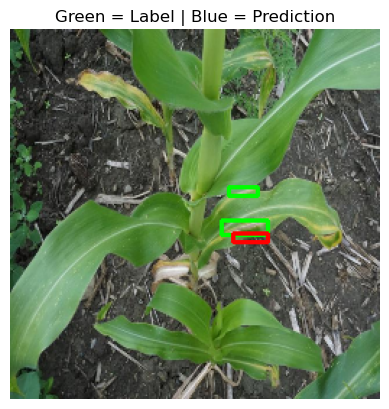

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


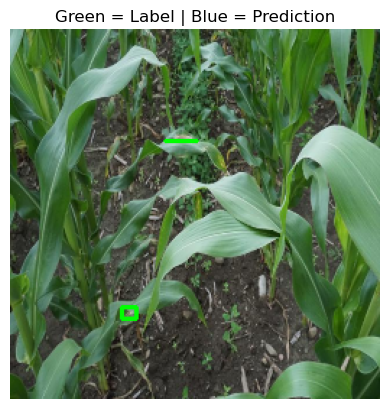

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


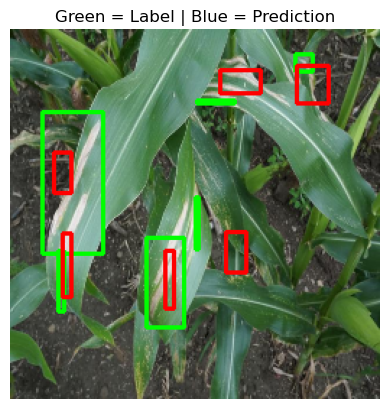

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


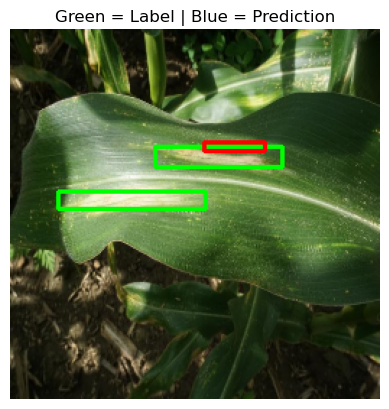

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


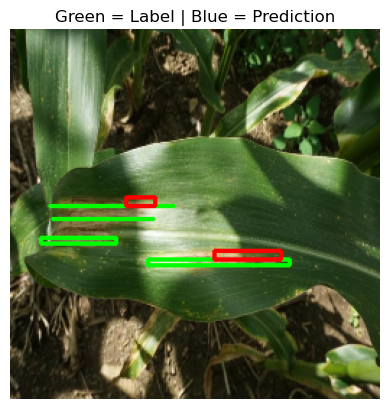

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


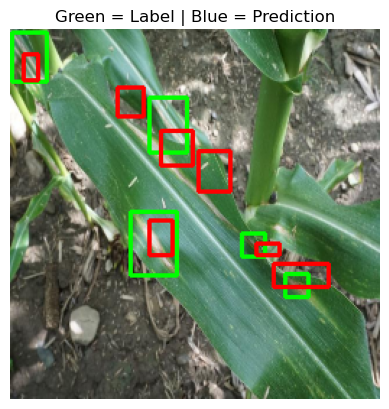

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


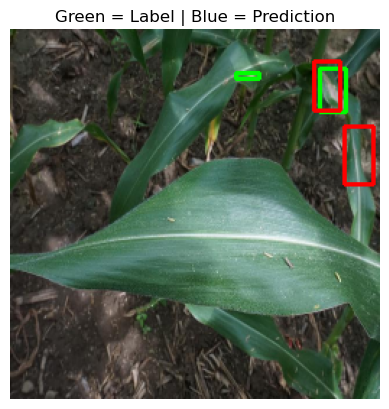

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


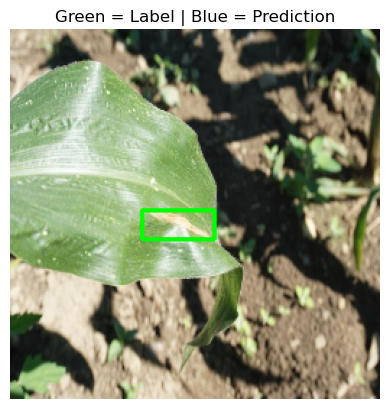

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


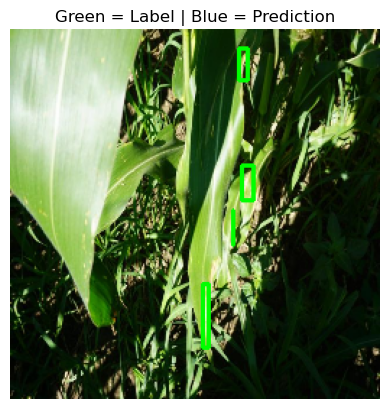

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


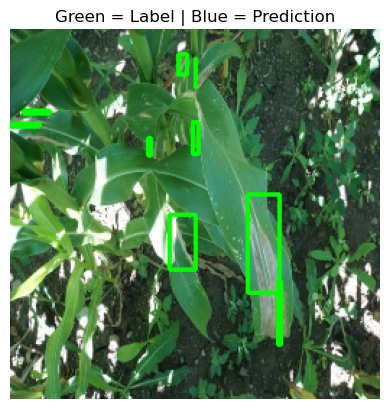

In [20]:
for i in range(10):
    image = x_val[i+10]
    label = y_val[i+10]          # shape (4,4,6)
    pred  = model.predict(image[np.newaxis])[0]  # shape (4,4,1,6)

    img = draw_boxes(image, label, pred)
    plt.imshow(img); plt.axis('off')
    plt.title("Green = Label | Blue = Prediction")
    plt.show()